In [53]:
# @title
!pip install feature-engine
!pip install holidays keras-tuner

In [54]:
# @title
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [55]:
df = pd.read_excel("/content/dataset.xlsx")
df

,Unnamed: 0,date,sales
0,0,2013-01-01,13
1,1,2013-01-02,11
2,2,2013-01-03,14
3,3,2013-01-04,13
4,4,2013-01-05,10
...,...,...,...
1821,1821,2017-12-27,14
1822,1822,2017-12-28,19
1823,1823,2017-12-29,15
1824,1824,2017-12-30,27


In [56]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [57]:
date_time = pd.DataFrame(df['date'])

In [58]:
df['date'] = df['date'].astype(str) + ' 00:00:00'

In [59]:
df.head()

,date,sales
0,2013-01-01 00:00:00,13
1,2013-01-02 00:00:00,11
2,2013-01-03 00:00:00,14
3,2013-01-04 00:00:00,13
4,2013-01-05 00:00:00,10


In [60]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sales,1826.0,19.971522,6.741022,4.0,15.0,19.0,24.0,50.0


In [61]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [62]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and converts it to signal (sine and cosine) to deal with periodicity.
    Input:
        df: DataFrame with a DateTime index
    Output:
        df: DataFrame with additional columns representing Sin/Cosine signals for timestamp, month, day, week, and year
    '''
    # Ensure the index is a datetime object
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24 * 60 * 60
    week = 7 * day
    year = 365.2425 * day

    # Extract month and day components
    df['Month'] = df.index.month
    df['Day_of_month'] = df.index.day

    # Apply cyclical features transformer to month and day columns
    cyclical_transformer = CyclicalFeatures(
        variables=['Month', 'Day_of_month'],  # specify the variable to transform
        drop_original=True  # drop the original variables
    )

    df = cyclical_transformer.fit_transform(df)

    df['Week sin'] = np.sin(2 * np.pi * timestamp_s / week)
    df['Week cos'] = np.cos(2 * np.pi * timestamp_s / week)

    df['Year sin'] = np.sin(2 * np.pi * timestamp_s / year)
    df['Year cos'] = np.cos(2 * np.pi * timestamp_s / year)

    return df



In [63]:
df = dateTimeToSignal(df)

In [64]:
df

,sales,Month_sin,Month_cos,Day_of_month_sin,Day_of_month_cos,Week sin,Week cos,Year sin,Year cos
date,,,,,,,,,
2013-01-01,13,5.000000e-01,0.866025,2.012985e-01,0.979530,-9.749279e-01,-0.222521,0.009848,0.999952
2013-01-02,11,5.000000e-01,0.866025,3.943559e-01,0.918958,-7.818315e-01,0.623490,0.027048,0.999634
2013-01-03,14,5.000000e-01,0.866025,5.712682e-01,0.820763,-1.801393e-13,1.000000,0.044240,0.999021
2013-01-04,13,5.000000e-01,0.866025,7.247928e-01,0.688967,7.818315e-01,0.623490,0.061418,0.998112
2013-01-05,10,5.000000e-01,0.866025,8.486443e-01,0.528964,9.749279e-01,-0.222521,0.078579,0.996908
...,...,...,...,...,...,...,...,...,...
2017-12-27,14,-2.449294e-16,1.000000,-7.247928e-01,0.688967,-7.818315e-01,0.623490,-0.079736,0.996816
2017-12-28,19,-2.449294e-16,1.000000,-5.712682e-01,0.820763,5.804087e-13,1.000000,-0.062577,0.998040
2017-12-29,15,-2.449294e-16,1.000000,-3.943559e-01,0.918958,7.818315e-01,0.623490,-0.045400,0.998969


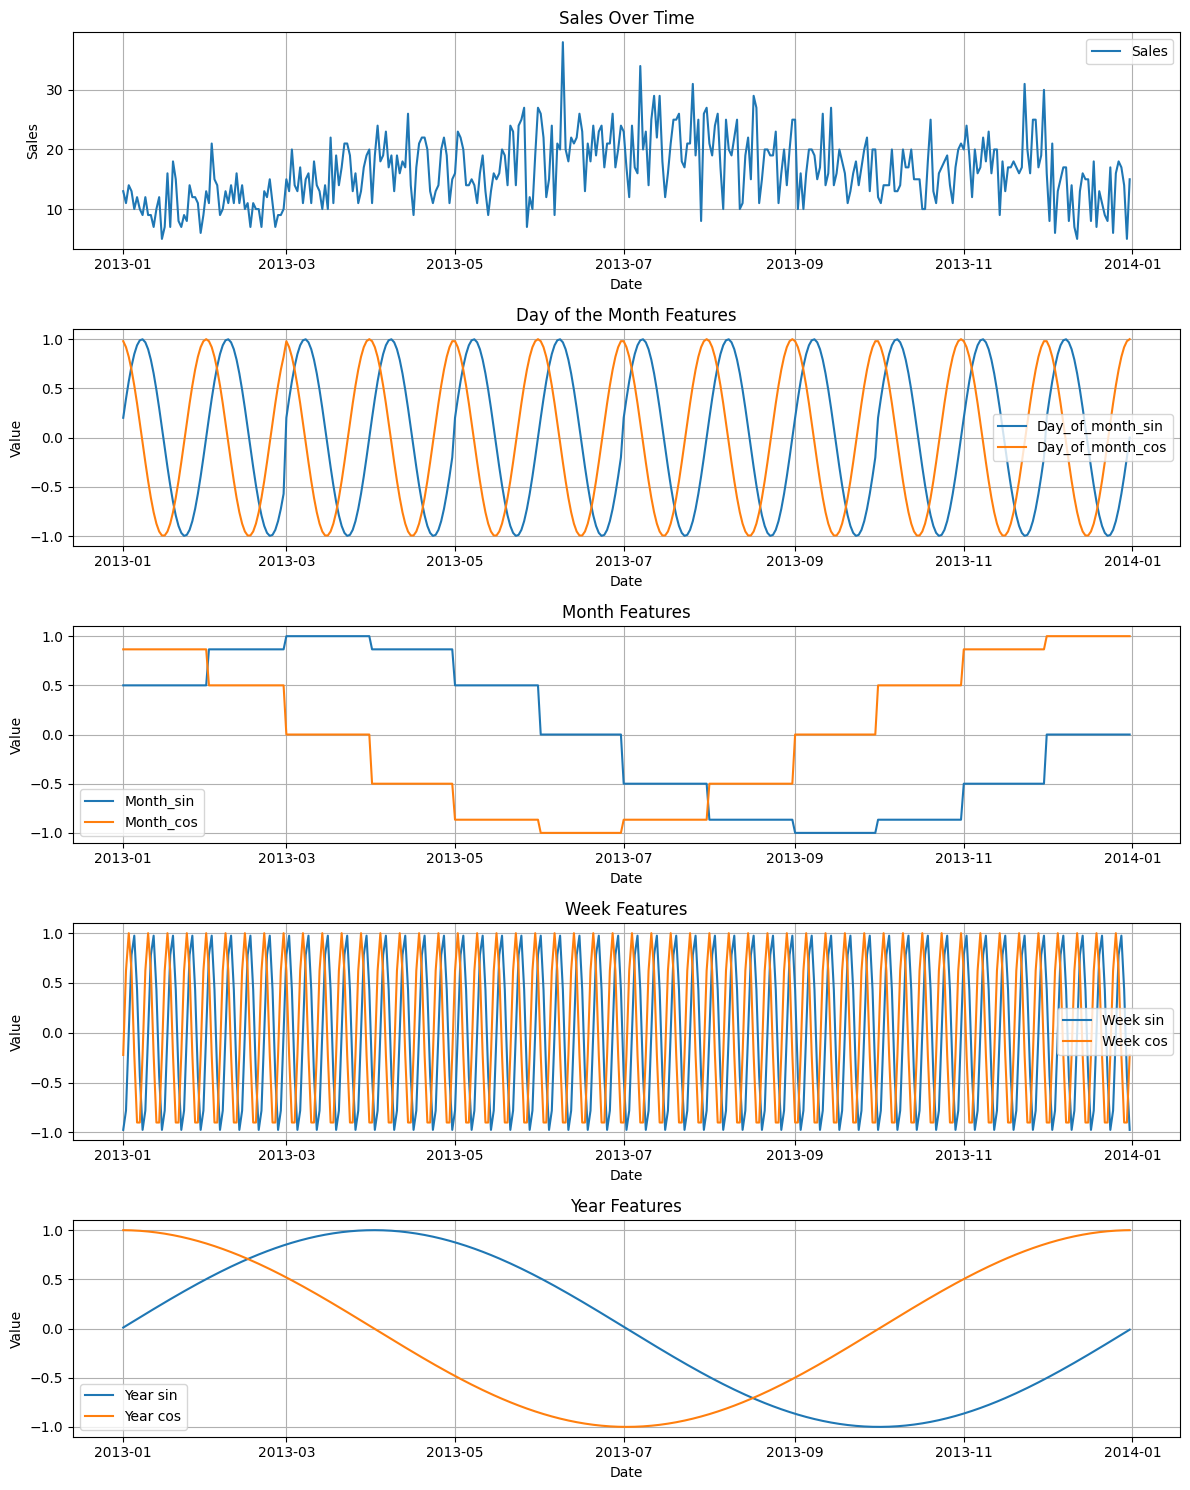

In [65]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

# Select a subset of the data based on the number of rows to display
subset_df = df.iloc[:365,]

# Plot the sales over time
axes[0].plot(subset_df.index, subset_df['sales'], label='Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].set_title('Sales Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot the sine and cosine features for day of the month
axes[1].plot(subset_df.index, subset_df['Day_of_month_sin'], label='Day_of_month_sin')
axes[1].plot(subset_df.index, subset_df['Day_of_month_cos'], label='Day_of_month_cos')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].set_title('Day of the Month Features')
axes[1].legend()
axes[1].grid(True)

# Plot the sine and cosine features for month
axes[2].plot(subset_df.index, subset_df['Month_sin'], label='Month_sin')
axes[2].plot(subset_df.index, subset_df['Month_cos'], label='Month_cos')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')
axes[2].set_title('Month Features')
axes[2].legend()
axes[2].grid(True)

# Plot the sine and cosine features for week
axes[3].plot(subset_df.index, subset_df['Week sin'], label='Week sin')
axes[3].plot(subset_df.index, subset_df['Week cos'], label='Week cos')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Value')
axes[3].set_title('Week Features')
axes[3].legend()
axes[3].grid(True)

# Plot the sine and cosine features for year
axes[4].plot(subset_df.index, subset_df['Year sin'], label='Year sin')
axes[4].plot(subset_df.index, subset_df['Year cos'], label='Year cos')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Value')
axes[4].set_title('Year Features')
axes[4].legend()
axes[4].grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Display the plots
plt.show()


In [66]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

In [67]:
df['is_holiday'] = df.index.map(is_holiday)
df['is_holiday']

date
2013-01-01    0
2013-01-02    0
2013-01-03    0
2013-01-04    0
2013-01-05    0
             ..
2017-12-27    0
2017-12-28    0
2017-12-29    0
2017-12-30    0
2017-12-31    0
Name: is_holiday, Length: 1826, dtype: int64

Most important frequencies:
Frequency: 0.002738225629791895, Period: 365.2 days
Frequency: 0.1429353778751369, Period: 6.996168582375479 days
Frequency: 0.000547645125958379, Period: 1826.0 days
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days


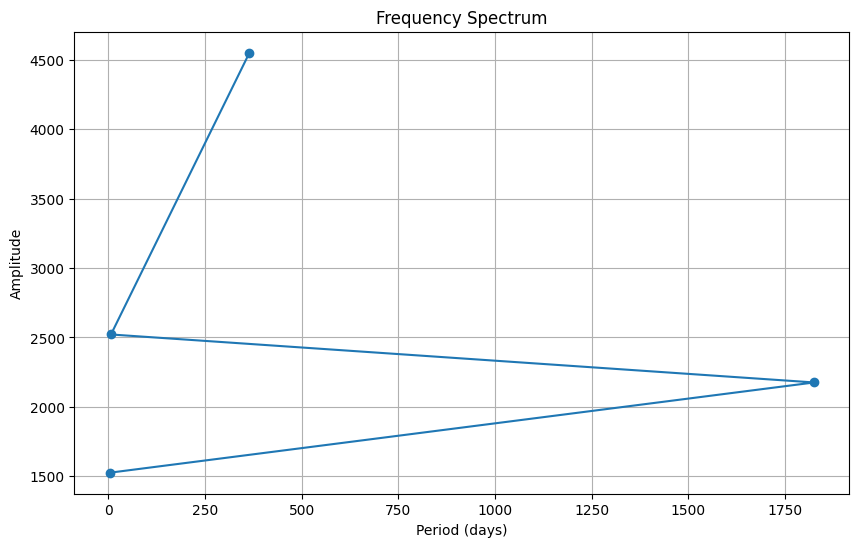

In [68]:
# Compute the FFT
sales_fft = np.fft.fft(df['sales'])

# Get the frequencies
n = len(df)
frequencies = np.fft.fftfreq(n)
positive_frequencies = frequencies[:n // 2]
amplitudes = np.abs(sales_fft[:n // 2])

# Find the most important frequencies
top_k = 5  # Number of top frequencies to display
top_indices = np.argsort(amplitudes)[::-1][:top_k]

# Plot the frequency spectrum, skipping the first frequency component
plt.figure(figsize=(10, 6))
plt.title("Frequency Spectrum")
plt.plot(1 / positive_frequencies[top_indices[1:]], amplitudes[top_indices[1:]], 'o-')
plt.xlabel("Period (days)")
plt.ylabel("Amplitude")
plt.grid(True)

# Show the most important frequencies, skipping the first one
print("Most important frequencies:")
for idx in top_indices[1:]:
    period = 1 / positive_frequencies[idx]
    print(f"Frequency: {positive_frequencies[idx]}, Period: {period} days")

# Display the plot
plt.show()

Here's an explanation of the output:

Frequency: 0.002738225629791895, Period: 365.2 days:

This frequency component corresponds to a period of approximately one year (365.2 days). It indicates a yearly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-year cycle, which is common in many businesses due to seasonal variations.
Frequency: 0.1429353778751369, Period: 6.996168582375479 days:

This frequency component corresponds to a period of approximately 7 days (6.996 days). It indicates a weekly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-week cycle. This may be related to weekly trends or behaviors in your data.
Frequency: 0.000547645125958379, Period: 1826.0 days:

This frequency component corresponds to a period of approximately 1826 days (about 5 years). It suggests a longer-term cycle or trend in the sales data that repeats every 5 years. This could be associated with macroeconomic or industry-specific factors.
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days:

This frequency component corresponds to a period of approximately 3.5 days. It indicates a short-term cycle or seasonality in the sales data, possibly related to daily fluctuations or events affecting sales on a daily basis.


In summary, the FFT analysis reveals the underlying periodic components in your sales data, helping you understand the different time scales at which patterns and seasonality occur. These insights can be valuable for forecasting, trend analysis, and understanding the dynamics of your sales data.

In [69]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = 1 # number of target feature

In [70]:
FEATURES = ['Month_sin', 'Month_cos', 'Day_of_month_sin','Day_of_month_cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos','is_holiday']

In [71]:
column_indices

{'sales': 0,
 'Month_sin': 1,
 'Month_cos': 2,
 'Day_of_month_sin': 3,
 'Day_of_month_cos': 4,
 'Week sin': 5,
 'Week cos': 6,
 'Year sin': 7,
 'Year cos': 8,
 'is_holiday': 9}

In [72]:
train_sales = train_df[['sales']]
test_sales = test_df[['sales']]
val_sales = val_df[['sales']]
val_df = val_df.drop(['sales'], axis=1)
train_df = train_df.drop(['sales'], axis=1)
test_df = test_df.drop(['sales'], axis=1)

In [73]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df['sales'] = train_sales[['sales']]
val_df['sales'] = val_sales[['sales']]
test_df['sales'] = test_sales[['sales']]

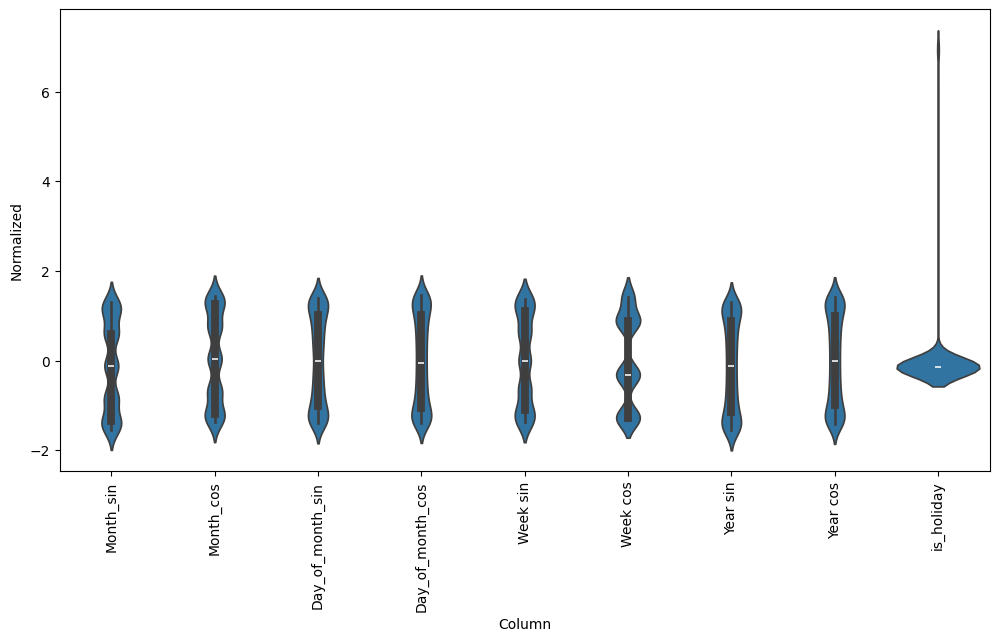

In [74]:
df2 = df.drop(['sales'], axis=1)
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [75]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [76]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['sales'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['sales']

In [77]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [78]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


In [79]:
w2.example = example_inputs, example_labels

In [80]:
def plot(self, model=None, plot_col='sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Period(day)')

WindowGenerator.plot = plot

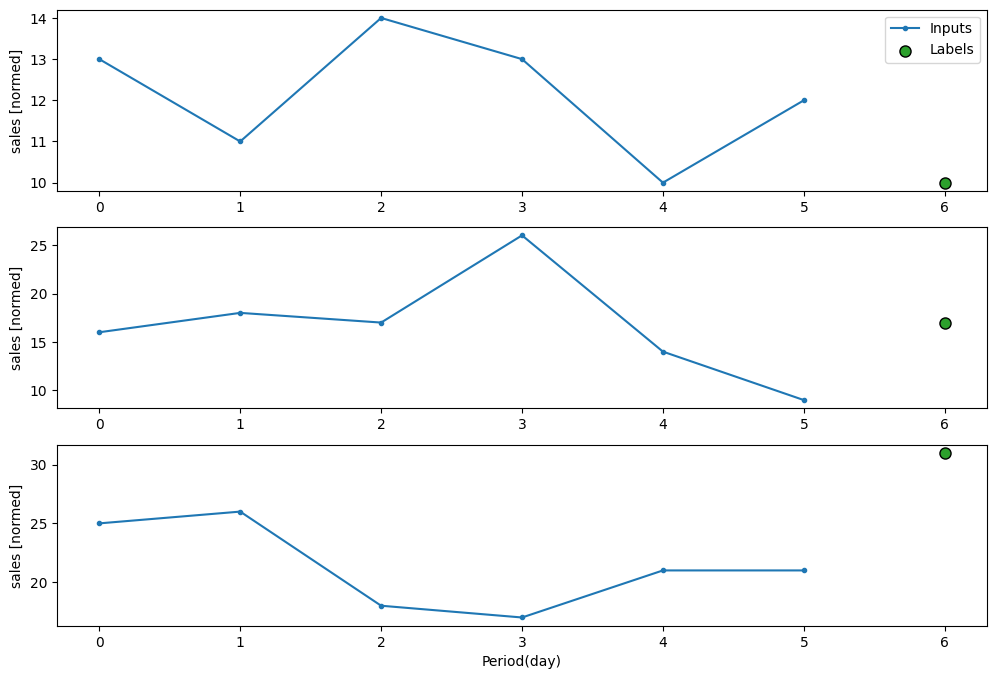

In [81]:
w2.plot()

In [82]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [83]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [84]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [85]:
OUT_STEPS = 24
single_step_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['sales'])
single_step_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['sales']

In [86]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 10)
Labels shape (batch, time, features): (32, 24, 1)


In [87]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(example_inputs)

tf.Tensor(
[[[ 5.9424645e-01  1.2600150e+00  2.7966034e-01 ...  1.4135592e+00
   -1.4405042e-01  1.3000000e+01]
  [ 5.9424645e-01  1.2600150e+00  5.5017376e-01 ...  1.4131105e+00
   -1.4405042e-01  1.1000000e+01]
  [ 5.9424645e-01  1.2600150e+00  7.9806471e-01 ...  1.4122435e+00
   -1.4405042e-01  1.4000000e+01]
  ...
  [ 5.9424645e-01  1.2600150e+00 -1.3588777e+00 ...  1.3173817e+00
   -1.4405042e-01  7.0000000e+00]
  [ 5.9424645e-01  1.2600150e+00 -1.4018097e+00 ...  1.3083669e+00
   -1.4405042e-01  9.0000000e+00]
  [ 5.9424645e-01  1.2600150e+00 -1.3874499e+00 ...  1.2989647e+00
   -1.4405042e-01  8.0000000e+00]]

 [[ 5.9424645e-01  1.2600150e+00  5.5017376e-01 ...  1.4131105e+00
   -1.4405042e-01  1.1000000e+01]
  [ 5.9424645e-01  1.2600150e+00  7.9806471e-01 ...  1.4122435e+00
   -1.4405042e-01  1.4000000e+01]
  [ 5.9424645e-01  1.2600150e+00  1.0131844e+00 ...  1.4109585e+00
   -1.4405042e-01  1.3000000e+01]
  ...
  [ 5.9424645e-01  1.2600150e+00 -1.4018097e+00 ...  1.3083669e+00

In [88]:
import numpy as np

# Creating a numpy array with shape (3, 2, 10)
example_array = np.random.rand(3, 2, 10)

print(example_array)

[[[0.9328044  0.27232315 0.39485359 0.93168098 0.19814108 0.08642714
   0.03520652 0.33678276 0.45000981 0.02056749]
  [0.25492077 0.47125398 0.80979188 0.07019554 0.89489807 0.9096828
   0.36673052 0.17103438 0.1573064  0.50473135]]

 [[0.07327625 0.07525414 0.82201237 0.93156021 0.06200477 0.84093583
   0.92121272 0.3414619  0.63406903 0.96651127]
  [0.82699265 0.06878059 0.5183588  0.18454913 0.77203692 0.3009856
   0.9367346  0.94764396 0.50359197 0.14994009]]

 [[0.44982667 0.93842778 0.5555247  0.18945903 0.6950786  0.92503495
   0.46301799 0.84463827 0.59756365 0.02092954]
  [0.11768959 0.82970083 0.71230884 0.15844229 0.91171789 0.28061025
   0.27725163 0.68945061 0.6725079  0.57606191]]]


## XAI

### ShapTime
https://github.com/Zhangyuyi-0825/ShapTime/tree/master

In [106]:
# @title
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional


# create super-time
def supertime(Tn, data):

    dfx = []
    lenth = int(len(data)/Tn)
    start = len(data) - (lenth * Tn)

    data_s = data[start:, :, :]

    for i in range(Tn):
        Ti = data_s[ i*lenth : (i+1)*lenth, :, : ]
        dfx.append(Ti)

    return dfx

def supertime_add(Tn, data):

    dfx = []
    lenth = int(len(data)/Tn)
    start = len(data) - (lenth * Tn)

    data_s = data.iloc[start: , :]

    for i in range(Tn):
        Ti = data_s.iloc[ i*lenth : (i+1)*lenth ]
        dfx.append(Ti)

    return dfx


# create ShapTime
def get_sub_set(Tn):

    mylist = list(range(Tn))
    sub_sets = [[]]
    for x in mylist:
        sub_sets.extend([item + [x] for item in sub_sets])
    return sub_sets


def ValFunction(model, interp_x, Tn):

    dfx = supertime(Tn, interp_x)
    # Generate subsets of indexes
    subset = get_sub_set(Tn)

    # Generate the baseline
    y_results = model.predict(interp_x)
    baseline = sum(y_results)/len(interp_x)

    val_results = []

    for i in range(1, len(subset)):
        x_i = dfx[subset[i][0]]

        if len(subset[i]) == 1:
            prediction = model.predict(x_i)
            results = (sum(prediction)/len(x_i)) - baseline
            val_results.append(results)

        else:
            for n in range(1, len(subset[i])):
                x_i = np.vstack([x_i, dfx[subset[i][n]]])

            prediction = model.predict(x_i)
            results = (sum(prediction)/len(x_i)) - baseline
            val_results.append(results)

    val_results.insert(0,0.0)

    return subset, val_results


def index(Si, subset):
    for i in range(len(subset)):
        if Si == subset[i]:
            index = i
        else:
            pass
    return index


def ShapleyValues(model, interp_x, Tn):

    subset, val_results = ValFunction(model, interp_x, Tn)
    shapley_values = []
    for i in range (Tn):
        shapley = []
        for n in range(len(subset)):
            if i not in subset[n]:
                Si = subset[n]+[i]
                Si.sort()
                Si_num = index(Si, subset)

                S_num = len(subset[n])
                N = Tn

                weight = (math.factorial(S_num) * math.factorial((N-S_num-1))) / math.factorial(N)
                val = val_results[Si_num] - val_results[n]
                shapley_i = weight * val

                shapley.append(shapley_i)
            else:
                pass

        shapley_values.append(sum(shapley))
        del shapley

    return shapley_values


def trans(original):
    results_exp = []
    for i in range(len(original)):
        results_exp.append(float(original[i]))
    return results_exp


def TimeImportance(Tn, ST_value, time_columns):
    time_list = list(range(Tn))
    shapley_impor = pd.DataFrame(index = time_list, columns = ['ShapTime'])
    shapley_impor['ShapTime'] = ST_value
    shapley_impor['absolute'] = abs(shapley_impor['ShapTime'])

    shapley_impor.index = time_columns
    shapley_impor.sort_values(by='absolute', inplace = True, ascending=False)

    sns.set(context='paper', style='ticks', font_scale=2)
    ax = sns.barplot(x="ShapTime", y=shapley_impor.index, data=shapley_impor, orient = 'h', color="lightskyblue", palette = 'Blues_r')
    plt.ylabel('Time Columns')
    plt.show()


def TimeHeatmap(Tn, ST_value, time_columns):
    time_list = list(range(Tn))
    shapley_df = pd.DataFrame(index = time_list, columns = ['ShapTime'])
    shapley_df['ShapTime'] = ST_value
    shapley_df_abs = abs(shapley_df)

    shapley_df_abs.index = time_columns
    sns.set(font_scale=1.3)
    f, ax = plt.subplots(figsize=(13, 1))
    sns.heatmap(shapley_df_abs.T, annot=False, linewidths=0, ax=ax, cmap = 'Blues')




In [89]:
train_df.head()

,Month_sin,Month_cos,Day_of_month_sin,Day_of_month_cos,Week sin,Week cos,Year sin,Year cos,is_holiday,sales
date,,,,,,,,,,
2013-01-01,0.594246,1.260015,0.279660,1.424202,-1.376953,-0.316852,-0.115625,1.413559,-0.14405,13
2013-01-02,0.594246,1.260015,0.550174,1.337768,-1.104017,0.879285,-0.091110,1.413110,-0.14405,11
2013-01-03,0.594246,1.260015,0.798065,1.197649,0.001078,1.411615,-0.066607,1.412243,-0.14405,14
2013-01-04,0.594246,1.260015,1.013184,1.009582,1.106173,0.879285,-0.042122,1.410959,-0.14405,13
2013-01-05,0.594246,1.260015,1.186726,0.781265,1.379109,-0.316852,-0.017663,1.409256,-0.14405,10


In [90]:
x_train = train_df.drop(columns = {'sales'}, axis = 1)
y_train = train_df.loc[:, ['sales']]

x_val = val_df.drop(columns = {'sales'}, axis = 1)
y_val = val_df.loc[:, ['sales']]

x_test = test_df.drop(columns = {'sales'}, axis = 1)
y_test = test_df.loc[:, ['sales']]

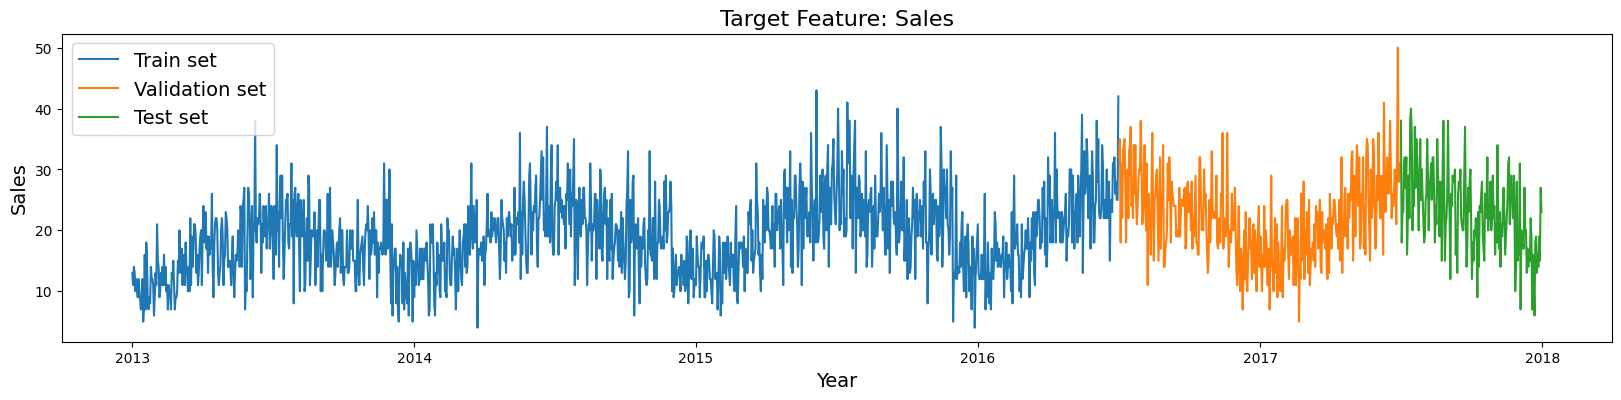

In [91]:
sns.reset_orig()
plt.figure(figsize = (20,4))
plt.title('Target Feature: Sales', fontsize = 16)
plt.plot(y_train['sales'], label = 'Train set')
plt.plot(y_val['sales'], label = 'Validation set')
plt.plot(y_test['sales'], label = 'Test set')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.legend(fontsize = 14)
plt.show()

In [92]:
x_train_sca = x_train.values[:].reshape(x_train.shape[0], 1, x_train.shape[1])
x_val_sca = x_val.values[:].reshape(x_val.shape[0], 1, x_val.shape[1])
x_test_sca = x_test.values[:].reshape(x_test.shape[0], 1, x_test.shape[1])

In [97]:
x_train_sca.shape

(1278, 1, 9)

In [98]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate, GRU, MaxPooling2D, MaxPooling1D
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

model = tf.keras.Sequential([
        Conv1D(320, 1, activation='relu', input_shape=(1, 9)),
        #MaxPooling1D(),
        Dense(480, activation='relu'),
        Bidirectional(LSTM(320, return_sequences=True)),
        Bidirectional(GRU(320*3, return_sequences=True)),
        Flatten(),
        Dense(1)])

# Compile the model
learning_rate = 1e-3  # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

In [99]:
history = model.fit(x_train_sca, y_train, batch_size=32, epochs=50)

Epoch 1/50
40/40 [==============================] - 9s 13ms/step - loss: 86.3107
Epoch 2/50
40/40 [==============================] - 0s 10ms/step - loss: 27.4802
Epoch 3/50
40/40 [==============================] - 0s 10ms/step - loss: 25.0111
Epoch 4/50
40/40 [==============================] - 0s 11ms/step - loss: 24.4525
Epoch 5/50
40/40 [==============================] - 0s 10ms/step - loss: 23.7515
Epoch 6/50
40/40 [==============================] - 0s 11ms/step - loss: 24.3225
Epoch 7/50
40/40 [==============================] - 0s 11ms/step - loss: 24.0137
Epoch 8/50
40/40 [==============================] - 0s 11ms/step - loss: 22.7647
Epoch 9/50
40/40 [==============================] - 0s 11ms/step - loss: 22.9713
Epoch 10/50
40/40 [==============================] - 0s 11ms/step - loss: 23.3410
Epoch 11/50
40/40 [==============================] - 0s 11ms/step - loss: 22.7074
Epoch 12/50
40/40 [==============================] - 0s 11ms/step - loss: 22.9427
Epoch 13/50
40/40 [======

In [100]:
test_df.shape

(183, 10)

In [101]:
prediction_bilstm = model.predict(x_test_sca)
prediction_bilstm = prediction_bilstm.reshape(183, 1)

6/6 [==============================] - 2s 13ms/step


In [102]:
r2 = r2_score(prediction_bilstm, y_test)
mse = mean_squared_error(prediction_bilstm, y_test)
print(r2)
print(mse)

-1.4000552346376756
42.37451490893814


In [107]:
Tn= 10
interp_x= x_train_sca

ShapTime_lstm = ShapleyValues(model, interp_x, Tn)

40/40 [==============================] - 0s 5ms/step


In [108]:
ShapTime_lstm

[array([-0.7476991], dtype=float32),
 array([1.0722235], dtype=float32),
 array([-0.73536193], dtype=float32),
 array([-0.27599835], dtype=float32),
 array([0.9764701], dtype=float32),
 array([-0.85925615], dtype=float32),
 array([0.13436154], dtype=float32),
 array([0.8358881], dtype=float32),
 array([-0.9951007], dtype=float32),
 array([0.63041043], dtype=float32)]

In [109]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

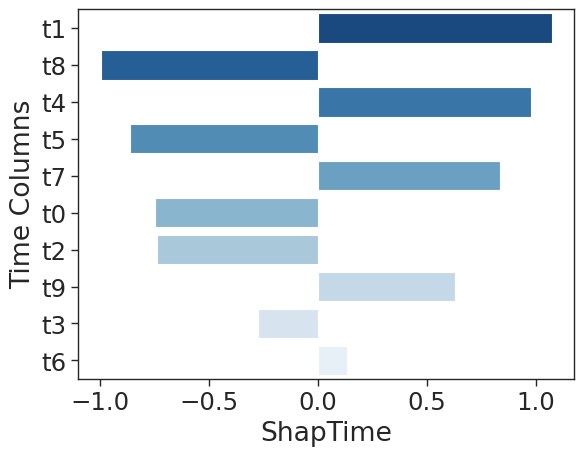

In [110]:
TimeImportance(Tn, trans(ShapTime_lstm), time_columns)

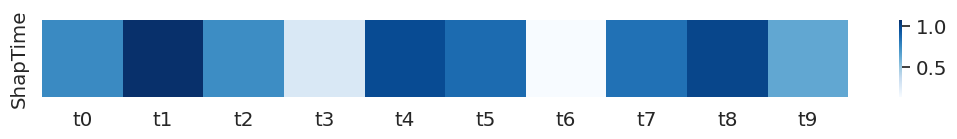

In [111]:
TimeHeatmap(Tn, trans(ShapTime_lstm), time_columns)

In [112]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train_df)[k]')

In [113]:
check_replist = [t0, t1, t2, t3, t4, t5, t1, t7, t8, t9]
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'sales'}, axis = 1)
y_check = check.loc[:, ['sales']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Conv1D(320, 1, activation='relu', input_shape=(1, 9)),
        #MaxPooling1D(),
        Dense(480, activation='relu'),
        Bidirectional(LSTM(320, return_sequences=True)),
        Bidirectional(GRU(320*3, return_sequences=True)),
        Flatten(),
        Dense(1)])



# Compile the model
learning_rate = 1e-3  # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_check.compile(loss='mse', optimizer=optimizer)

history = model_check.fit(x_check_sca, y_check, batch_size=32, epochs=50)

Epoch 1/50
40/40 [==============================] - 7s 12ms/step - loss: 85.5269
Epoch 2/50
40/40 [==============================] - 0s 11ms/step - loss: 27.2680
Epoch 3/50
40/40 [==============================] - 0s 11ms/step - loss: 25.9459
Epoch 4/50
40/40 [==============================] - 0s 11ms/step - loss: 25.0564
Epoch 5/50
40/40 [==============================] - 0s 10ms/step - loss: 24.8330
Epoch 6/50
40/40 [==============================] - 0s 10ms/step - loss: 23.8015
Epoch 7/50
40/40 [==============================] - 0s 10ms/step - loss: 23.0648
Epoch 8/50
40/40 [==============================] - 0s 11ms/step - loss: 22.7327
Epoch 9/50
40/40 [==============================] - 0s 11ms/step - loss: 22.8692
Epoch 10/50
40/40 [==============================] - 1s 13ms/step - loss: 21.6388
Epoch 11/50
40/40 [==============================] - 1s 13ms/step - loss: 22.4562
Epoch 12/50
40/40 [==============================] - 1s 13ms/step - loss: 22.3092
Epoch 13/50
40/40 [======

In [114]:
pred_check = model_check.predict(x_test_sca)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 2s 5ms/step
-0.8736538332778916 Degree of Improvement: 37.60%
44.81340726124615 Degree of Improvement: -5.76%


### Perturbation Analysis

https://stats.stackexchange.com/questions/191855/variable-importance-in-rnn-or-lstm

In [116]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 12.0 MB/s eta 0:00:00


In [117]:
x_train.columns.tolist()

['Month_sin',
 'Month_cos',
 'Day_of_month_sin',
 'Day_of_month_cos',
 'Week sin',
 'Week cos',
 'Year sin',
 'Year cos',
 'is_holiday']

In [128]:

orig_out = model.predict(x_test_sca)
for i in range(len(x_train.columns.tolist())):  # iterate over the all features
    new_x = x_test_sca.copy()
    perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model.predict(new_x)
    effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
    print(f'Variable {i+1}, perturbation effect: {effect:.4f}')

6/6 [==============================] - 0s 7ms/step
Variable 1, perturbation effect: 0.3647
6/6 [==============================] - 0s 8ms/step
Variable 2, perturbation effect: 0.4400
6/6 [==============================] - 0s 16ms/step
Variable 3, perturbation effect: 0.4081
6/6 [==============================] - 0s 8ms/step
Variable 4, perturbation effect: 0.2892
6/6 [==============================] - 0s 7ms/step
Variable 5, perturbation effect: 0.7484
6/6 [==============================] - 0s 6ms/step
Variable 6, perturbation effect: 0.4789
6/6 [==============================] - 0s 5ms/step
Variable 7, perturbation effect: 0.5380
6/6 [==============================] - 0s 5ms/step
Variable 8, perturbation effect: 0.3228
6/6 [==============================] - 0s 6ms/step
Variable 9, perturbation effect: 0.1418


In [133]:
x_train.columns

Index(['Month_sin', 'Month_cos', 'Day_of_month_sin', 'Day_of_month_cos',
       'Week sin', 'Week cos', 'Year sin', 'Year cos', 'is_holiday'],
      dtype='object')

In [132]:
[x_train.columns.tolist()[i] for i in sorted_indices]

['Week sin',
 'Month_cos',
 'Week cos',
 'Year sin',
 'Day_of_month_sin',
 'Month_sin',
 'Day_of_month_cos',
 'Year cos',
 'is_holiday']

6/6 [==============================] - 0s 7ms/step


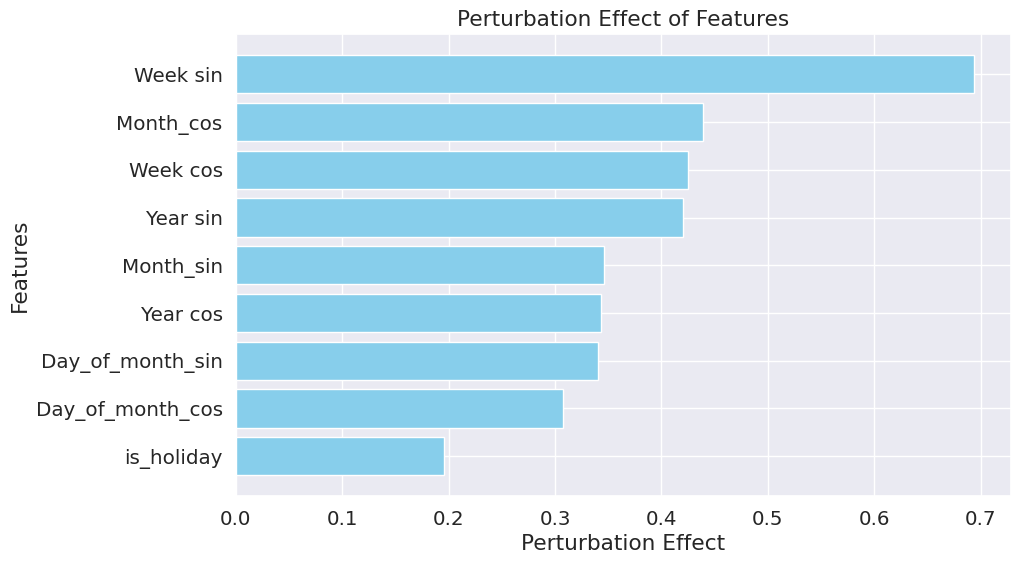

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate perturbation effect for each feature
effects = []
orig_out = model.predict(x_test_sca)
for i in range(len(x_train.columns.tolist())):
    new_x = x_test_sca.copy()
    perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model.predict(new_x)
    effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
    effects.append(effect)

# Sort features based on their effect
sorted_indices = np.argsort(effects)[::-1]
sorted_effects = [effects[i] for i in sorted_indices]
sorted_features = [x_train.columns.tolist()[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_effects)), sorted_effects, color='skyblue')
plt.xlabel('Perturbation Effect')
plt.ylabel('Features')
plt.title('Perturbation Effect of Features')
plt.yticks(range(len(sorted_effects)), [f'{i}' for i in sorted_features])
plt.gca().invert_yaxis()  # Invert y-axis to display highest effect at the top
plt.show()
